# Simple Diffusion Processes with Resetting

#### A standard discrete-time random walk evolves by updating the position at each step by either +1 or −1 with some probability. Let the walk be defined by:
$$
x_{t+1} = \begin{cases}
x_0 & \text{with probability } \; r \text{ (reset)}\\\\
x_t + \eta_t & \text{with probability } \; 1-r
\end{cases}
$$
where:
* $\eta_t = \pm 1$ with probability $P$ and $1-P$
* $r\in[0,1]$ is the resetting probability at each discrete time step
* Reset always returns the walker to origin $x_0$

NB: np.random.rand() samples a uniform random number in $[0,1)$. If it’s less than $r$, the walker resets.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

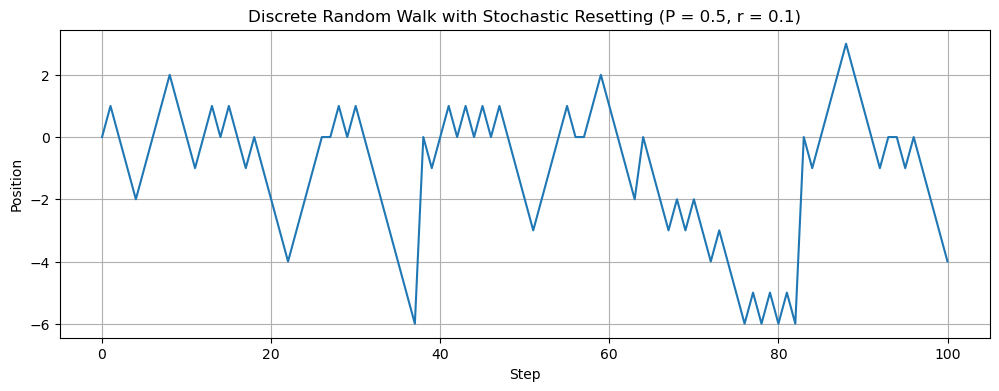

In [1]:
def discrete_random_walk(P, T):
    steps = np.zeros(T)
    for t in range(T):
        p = np.random.rand()
        if P >= p:
            steps[t] = +1
        else:
            steps[t] = -1
    return steps

def discrete_random_walk_with_resetting(P, T, reset_prob):
    steps = discrete_random_walk(P, T)
    position = 0
    trajectory = [position]

    for step in steps:
        if np.random.rand() < reset_prob:
            position = 0  # Reset to origin
        else:
            position += step
        trajectory.append(position)

    return trajectory

# Parameters
P = 0.5          # Probability of stepping right
T = 100         # Number of time steps
reset_prob = 0.1  # Resetting probability

# Run and plot
traj = discrete_random_walk_with_resetting(P, T, reset_prob)
plt.figure(figsize=(12, 4))
plt.plot(traj)
plt.title('Discrete Random Walk with Stochastic Resetting (P = {}, r = {})'.format(P, reset_prob))
plt.xlabel('Step')
plt.ylabel('Position')
plt.grid(True)
plt.show()

#### In continuous time, stochastic resetting is applied to Brownian motion. The evolution of the position $x(t)$ follows the stochastic differential equation (SDE):
$$
dx(t) = \sqrt{2D}dW(t)
$$
and $dW(t)≈ξ_t \sqrt{dt}$ (Euler–Maruyama Scheme)

but with a resetting process:
$$
x_{t+dt} = \begin{cases}
x_0, & \text{with probability } \; r\cdot dt \text{ (reset)}\\\\
x(t) +  \sqrt{2D}\cdot ξ_t \sqrt{dt} & \text{with probability } \; 1-r \cdot dt
\end{cases}
$$
where:
* $D$ is the diffusion constant
* $𝜉_t ∼ N(0,1)$ is Gaussian white noise
* $r$ is the resetting rate (per unit time)
* $dt$ is the time step used in numerical simulation

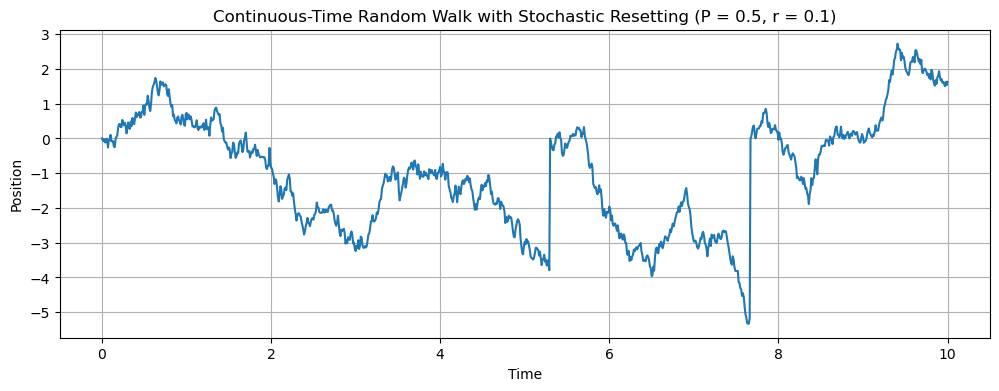

In [3]:
def continuous_random_walk_with_resetting(T=10, dt=0.01, D=1.0, r=0.1):
    N = int(T / dt)
    position = 0.0
    trajectory = [position]

    for _ in range(N):
        if np.random.rand() < r * dt:  # Reset with rate r
            position = 0.0
        else:
            dW = np.sqrt(dt) * np.random.randn()
            position += np.sqrt(2 * D) * dW
        trajectory.append(position)

    time = np.linspace(0, T, N + 1)
    return time, trajectory

# Run and plot
time, traj = continuous_random_walk_with_resetting()
plt.figure(figsize=(12, 4))
plt.plot(time, traj)
plt.title('Continuous-Time Random Walk with Stochastic Resetting (P = {}, r = {})'.format(P, reset_prob))
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.show()

## Position distribution at Large Times

### Analytical Position Distributions for Diffusion With and Without Resetting

#### 1. Without Resetting (Pure Diffusion)
For a Brownian particle starting at position \( x_0 \), the probability density function at time \( T \) is:
$$
P(x, T) = \frac{1}{\sqrt{4\pi D T}} \exp\left( -\frac{(x - x_0)^2}{4 D T} \right)
$$

This is a **Gaussian distribution** centered at \( x_0 \), with variance \( \sigma^2 = 2DT \).

#### 2. With Stochastic Resetting
When the particle resets to \( x_0 \) at a constant rate \( r \), the system reaches a **stationary state** with the distribution:
$$
p_{\text{st}}(x \mid x_0) = \frac{1}{2} \sqrt{\frac{r}{D}} \exp\left( - \sqrt{\frac{r}{D}} \, |x - x_0| \right)
$$

This shows **exponential localization** around the reset point.

#### 📄 Reference:
Evans, M. R., & Majumdar, S. N. (2011). *Diffusion with Stochastic Resetting*.  
**Physical Review Letters**, 106(16), 160601.  
[DOI: 10.1103/PhysRevLett.106.160601](https://doi.org/10.1103/PhysRevLett.106.160601)


In [ ]:
def simple_diffusion_with_resetting(T=10, dt=0.1, D=1.0, r=0.1, x0=0.0):
    """
    Simulate a single trajectory of simple diffusion with resetting.
    """
    N = int(T / dt)
    x = x0
    for _ in range(N):
        if np.random.rand() < r * dt:
            x = x0
        else:
            x += np.sqrt(2 * D * dt) * np.random.randn()
    return x

def simulate_final_positions(T, dt, D, r, x0, N_sim):
    """
    Simulate many walkers and return array of final positions.
    """
    return np.array([simple_diffusion_with_resetting(T, dt, D, r, x0) for _ in range(N_sim)])

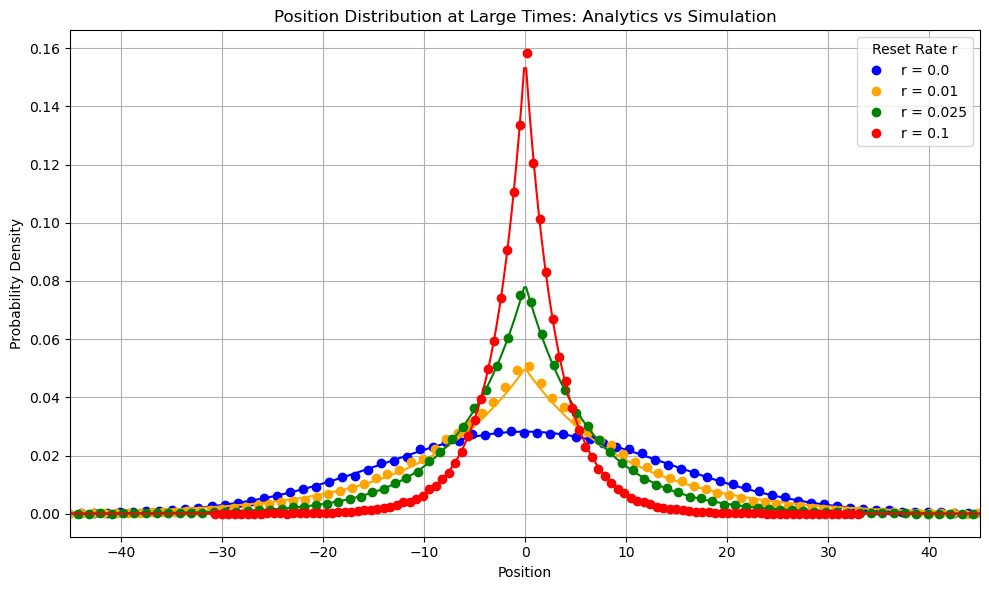

In [23]:
def analytical_distribution(x, r, D, T, x0):
    if r == 0:
        # Gaussian for free diffusion
        sigma2 = 2 * D * T
        return (1 / np.sqrt(4 * np.pi * D * T)) * np.exp(- (x - x0)**2 / (4 * D * T))
    else:
        # Exponential stationary distribution
        prefactor = 0.5 * np.sqrt(r / D)
        return prefactor * np.exp(- np.sqrt(r / D) * np.abs(x - x0))

def plot_comparison(T, dt, D, r_values, x0=0.0, N_sim=100000, bins=100):
    plt.figure(figsize=(10, 6))
    
    x_vals = np.linspace(-50, 50, 500)
    
    color_map = {
        0.0: 'blue',
        0.01: 'orange',
        0.025: 'green',
        0.1: 'red'
    }

    for i, r in enumerate(r_values):
        color = color_map.get(r, 'black')

        # Simulated data
        positions = simulate_final_positions(T, dt, D, r, x0, N_sim)
        counts, bin_edges = np.histogram(positions, bins=bins, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Add label only once per color (i.e., for the first plot)
        label = f"r = {r}"
        plt.plot(bin_centers, counts, 'o', color=color, label=label)
        plt.plot(x_vals, analytical_distribution(x_vals, r, D, T, x0), '-', color=color)

    plt.title(f"Position Distribution at Large Times: Analytics vs Simulation")
    plt.xlabel("Position")
    plt.ylabel("Probability Density")
    plt.xlim(-45,45)
    plt.legend(title="Reset Rate r", loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
T = 100
dt = 0.1
D = 1.0
x0 = 0.0
N_sim = 100000
r_values = [0.0, 0.01, 0.025, 0.1]

plot_comparison(T, dt, D, r_values, x0, N_sim, bins=100)